# Get individual leaves

Now that we have individual pots, we need to identify individual leaves

**Currently stuck at trying to get _every_ leaf tip, to then run a watershed segmentation**

In [1]:
import tifffile as tf
import numpy as np
import pandas as pd

import glob
import numpy.polynomial.polynomial as P
from scipy import spatial
from scipy import interpolate
from scipy import ndimage

from sklearn import neighbors
from importlib import reload

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/Day6_110821_U112-3.tif'
tiff_file = '../raw3d/Day7_110921_U112-3.tif'
pot_src = '../pots/'

_, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

src = pot_src + bname + '/'

In [4]:
potfiles = sorted(glob.glob(src + bname + '_pot*.tif'))
potfiles

['../pots/Day7_110921_U112-3/Day7_110921_U112-3_pot0.tif',
 '../pots/Day7_110921_U112-3/Day7_110921_U112-3_pot1.tif',
 '../pots/Day7_110921_U112-3/Day7_110921_U112-3_pot2.tif',
 '../pots/Day7_110921_U112-3/Day7_110921_U112-3_pot3.tif']

In [5]:
pot = [None for i in range(len(potfiles))]

for i in range(len(pot)):
    foo = tf.imread(potfiles[i])
    pot[i]  = foo
#    print(np.sum(pot[i] > 0))

In [112]:
pidx = 2
img = pot[pidx].copy()
img[img < 50] = 0
img, ceros, cerosshape = thales.clean_zeroes(img)

print(np.max(img))

leaf_dst = '../leaves/'
dst = leaf_dst + bname + '/' + 'pot{}/'.format(pidx)
if not os.path.isdir(dst):
    os.makedirs(dst)
print('All results will be saved in ', dst)

75 % reduction from input
255
All results will be saved in  ../leaves/Day7_110921_U112-3/pot2/


In [113]:
foo = thales.get_largest_element(img)
img = foo*img

74591 components
[52895535     2631     1302      987      864      852      654      594
      546      539      482      478      478      474      443      425
      421      394      366      357]


[(inf, None, 49), (509395, 84, 155), (358369, 253, 254), (8188, 141, 140), (7094, 113, 112), (1532, 91, 87), (1049, 170, 171), (599, 93, 92), (531, 86, 85), (70, 89, 90)]
96


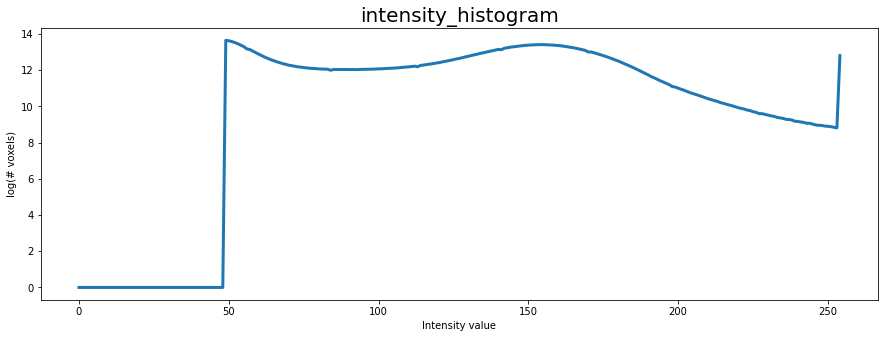

In [114]:
#foo = timg.copy()
thr = thales.get_individual_threshold(img, True)
print(thr)

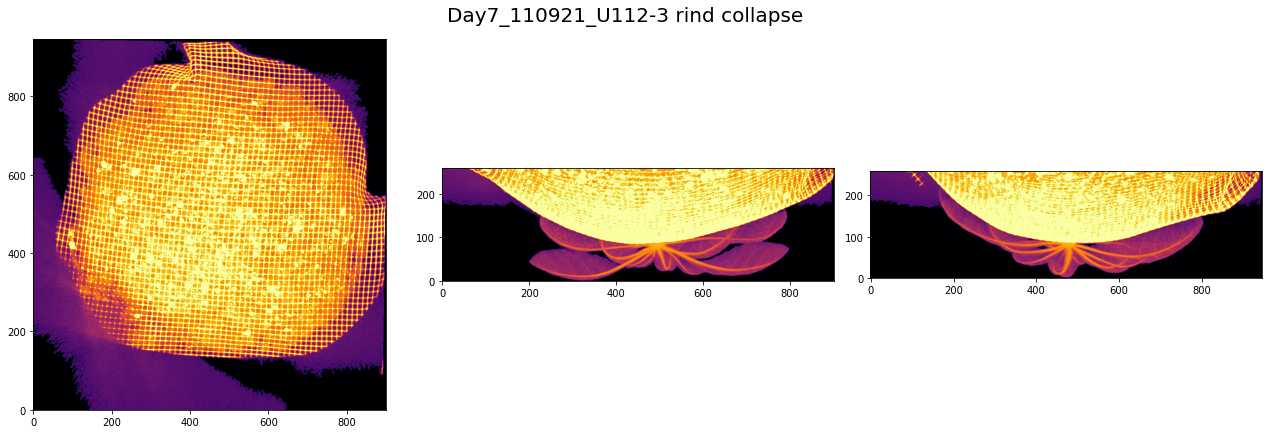

In [115]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions_max(img)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=True, dst=dst)

In [120]:
timg = img.copy()
timg[timg < 205] = 0

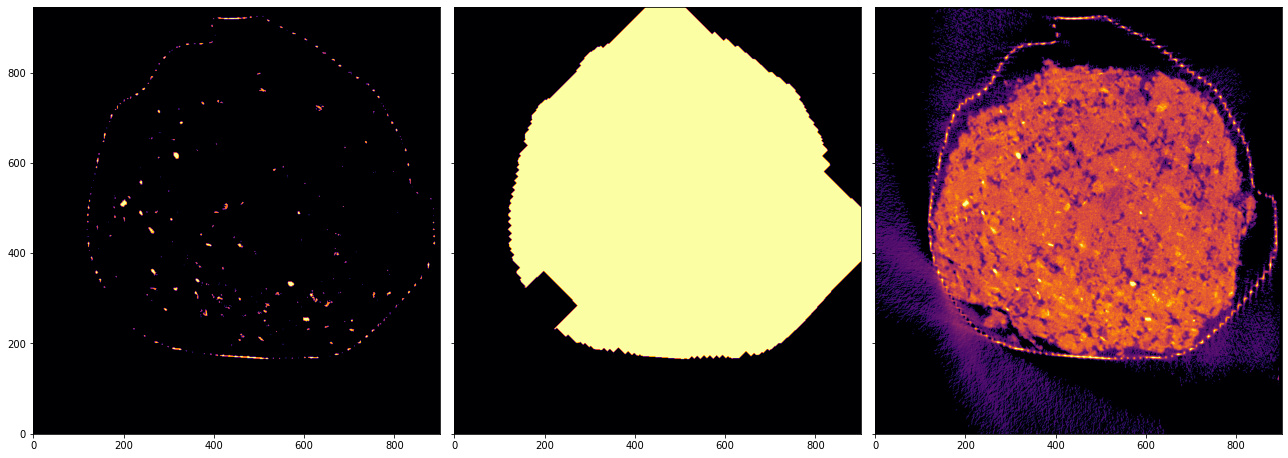

In [121]:
ss = np.s_[225,:, :]
iters = 50

fill = ndimage.binary_dilation(timg[ss], iterations=iters)
fill = ndimage.binary_dilation(fill, iterations=8, border_value=0)
fill = ndimage.binary_erosion(fill, iterations=8, border_value=1)

fill = ndimage.binary_fill_holes(fill)
#fill = ndimage.binary_closing(fill, iterations=4)
fill = ndimage.binary_erosion(fill, iterations=iters, border_value=1)
#fill = ndimage.binary_opening(fill, iterations=iters)

fig, ax = plt.subplots(1, 3, figsize=(18,8), sharex=True, sharey=True)

ax[0].imshow(timg[ss], cmap='inferno', origin='lower');
ax[1].imshow(fill, cmap='inferno', origin='lower');
ax[2].imshow(img[ss], cmap='inferno', origin='lower');

fig.tight_layout();

In [122]:
iters = 50
soil = np.zeros_like(img)

for i in range(img.shape[0]):
    ss = np.s_[i, :, :]
    fill = ndimage.binary_dilation(timg[ss], iterations=iters)
    
    fill = ndimage.binary_dilation(fill, iterations=8, border_value=0)
    fill = ndimage.binary_erosion(fill, iterations=8, border_value=1)

    fill = ndimage.binary_fill_holes(fill)
    ndimage.binary_erosion(fill, iterations=iters, output=soil[ss], border_value=1)

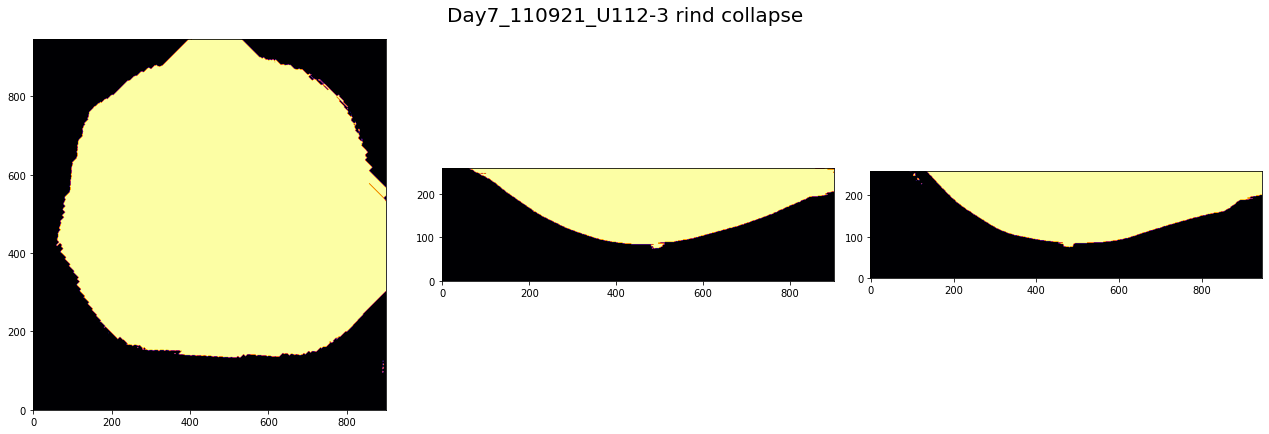

In [123]:
snaps = thales.collapse_dimensions_max(soil)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=False, dst=diag_dst)

In [124]:
its = 2
struc = ndimage.generate_binary_structure(timg.ndim, timg.ndim)

#dsoil = ndimage.binary_erosion(soil, struc, iterations=its, border_value=1)
dsoil = ndimage.binary_dilation(soil, struc, iterations=2*its, border_value=0)

In [133]:
plant = ~dsoil*img.copy()
#plant[plant > 200] = 0
plant[plant < 70] = 0

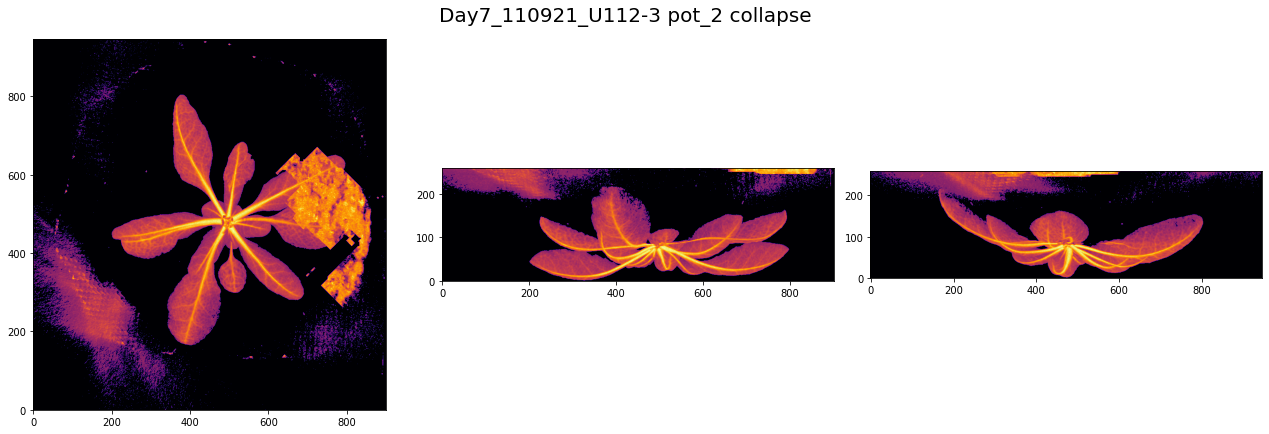

In [134]:
snaps = thales.collapse_dimensions_max(plant)
thales.plot_collapse_dimensions(snaps, bname, 'pot_'+ str(pidx), display=display, writefig=writefig, dst=diag_dst)

# Separate connected components

Find where the soil ends.

- Count the number of nonzero voxels per slice.
- We should see a drop past the soil level.

Find separate connected components after removing all the soil-related layers

In [135]:
labels,num = ndimage.label(plant, structure=ndimage.generate_binary_structure(plant.ndim, 1))
regions = ndimage.find_objects(labels)
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

18796 [820178 352299 321651   1209    631    626    597    521    467    400
    355    347    315    312    301    299    293    267    258    247]


In [136]:
means = ndimage.mean(plant, labels, np.arange(1,num+1))

In [137]:
cutoff = 1e-3
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(img.ndim, 2)
Comps = []

for j in range(len(regions)):
    i = argsort_hist[j]
    r = regions[i]
    if(hist[i]/sz_hist > cutoff):
        mask = labels==i+1
        box = plant.copy()
        box[~mask] = 0
        
        snaps = thales.collapse_dimensions_max(box)
        Comps.append(snaps)
        
        print(j, np.around(100*hist[i]/sz_hist, 3), np.around(means[i]), sep='\t')
        
print('Large components: ', len(Comps))

0	52.104	98.0
1	22.381	83.0
2	20.434	126.0
Large components:  3


IndexError: list index out of range

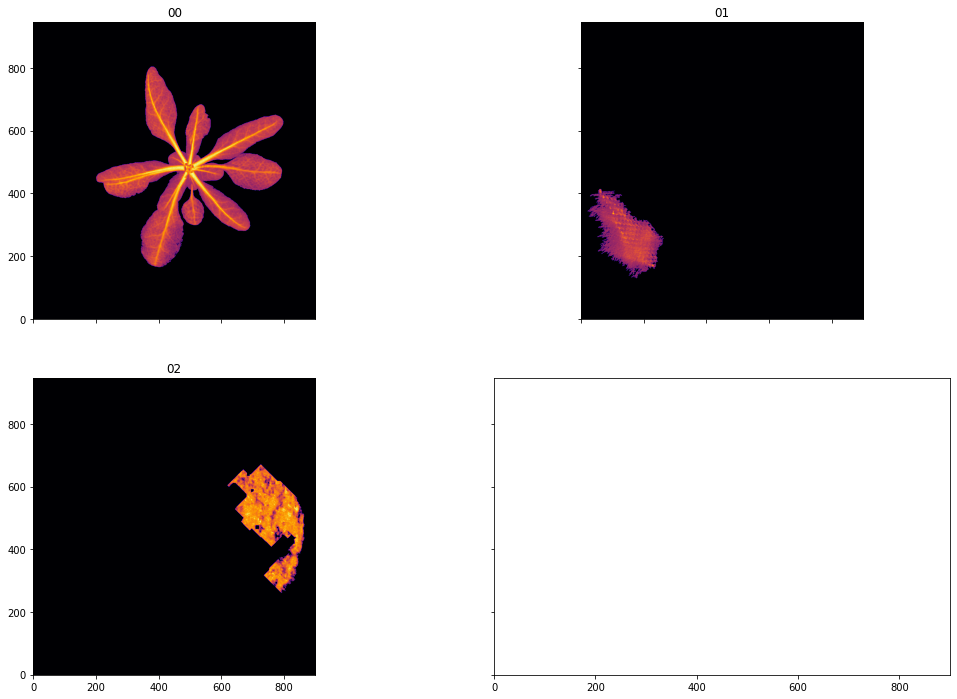

In [138]:
fig, ax = plt.subplots(2,2, figsize=(18,12), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [75]:
j = 3
i = argsort_hist[j]
r = regions[i]
if(hist[i]/sz_hist > cutoff):
    mask = labels==i+1
    box = plant.copy()
    box[~mask] = 0
    box[box < 70] = 0

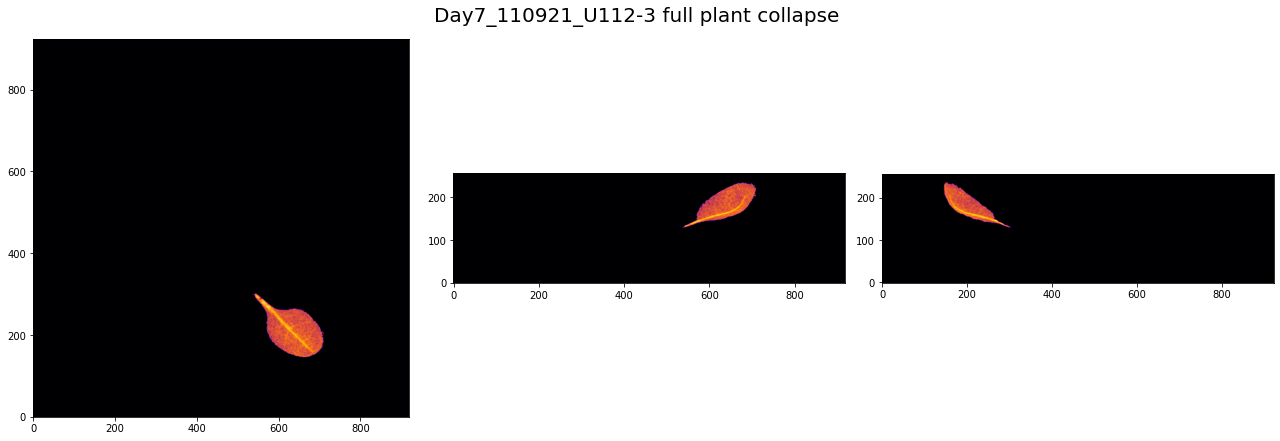

In [78]:
snaps = thales.collapse_dimensions_max(box)
thales.plot_collapse_dimensions(snaps, bname, 'full plant')

In [77]:
foo = thales.get_largest_element(box)
box = box*foo

96 components
[61959    33    16    13    11    10     9     8     8     8     7     7
     7     6     5     5     4     3     3     3]


In [140]:
arab = np.zeros_like(img)

for j in range(len(regions)):
    i = argsort_hist[j]
    r = regions[i]
    if((hist[i]/sz_hist > cutoff) and (means[i] > 95) and (means[i] < 110)):
        mask = labels==i+1
        box = plant.copy()
        box[~mask] = 0
        #if j == 3:
        #    box = box*foo
        arab += box

        print(j, np.around(100*hist[i]/sz_hist, 3), np.around(means[i]), sep='\t')

0	52.104	98.0


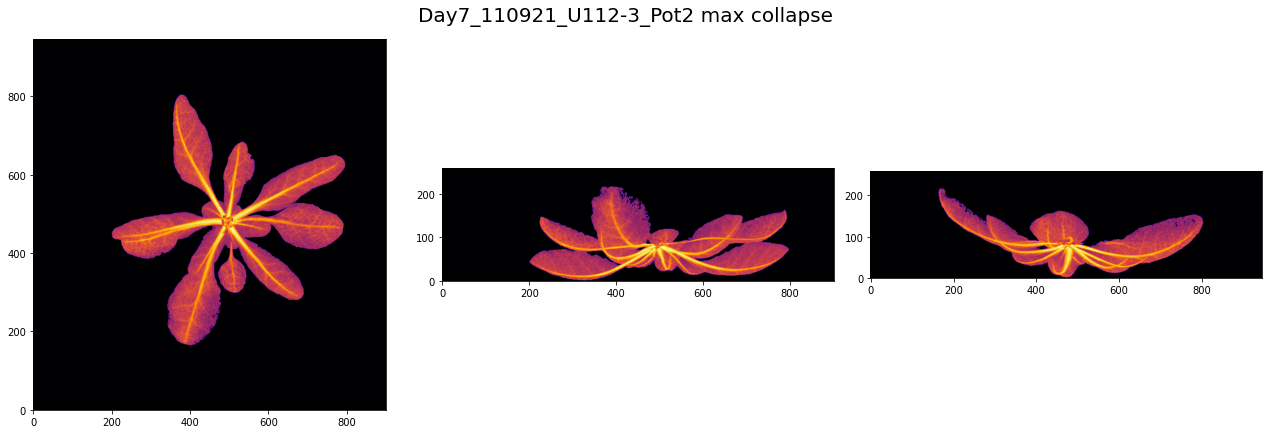

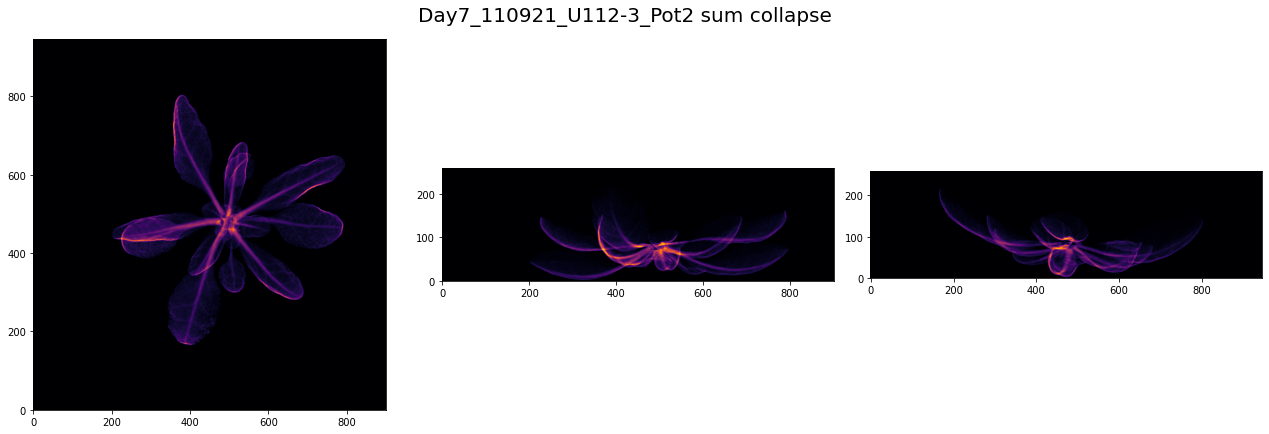

In [141]:
writefig = True
title = bname + '_Pot' + str(pidx)

snaps = thales.collapse_dimensions_max(arab)
thales.plot_collapse_dimensions(snaps, title, 'max', display=display, writefig=writefig, dst=dst)

snaps = thales.collapse_dimensions(arab)
thales.plot_collapse_dimensions(snaps, title, 'sum', display=display, writefig=writefig, dst=dst)

In [142]:
filename = dst + bname + '_pot{}_clean.tif'.format(pidx) 
tf.imwrite(filename, arab, photometric='minisblack',compress=3)

# Retouch the plant

Renumber the labels so they go from high to low.
- Label `1` corresponds to the largest connected component
- Label `2` corresponds to the second largest connected component
- And so on

In [66]:
bin_arab = arab.copy()
bin_arab[bin_arab > 0] = 1
its = 20
carab = ndimage.binary_dilation(bin_arab, iterations=its, border_value=0)
carab = ndimage.binary_erosion(carab, iterations=its, border_value=1)

- Select only labels that correspond to leaves. Ignore labels that correspond to soil or pot.

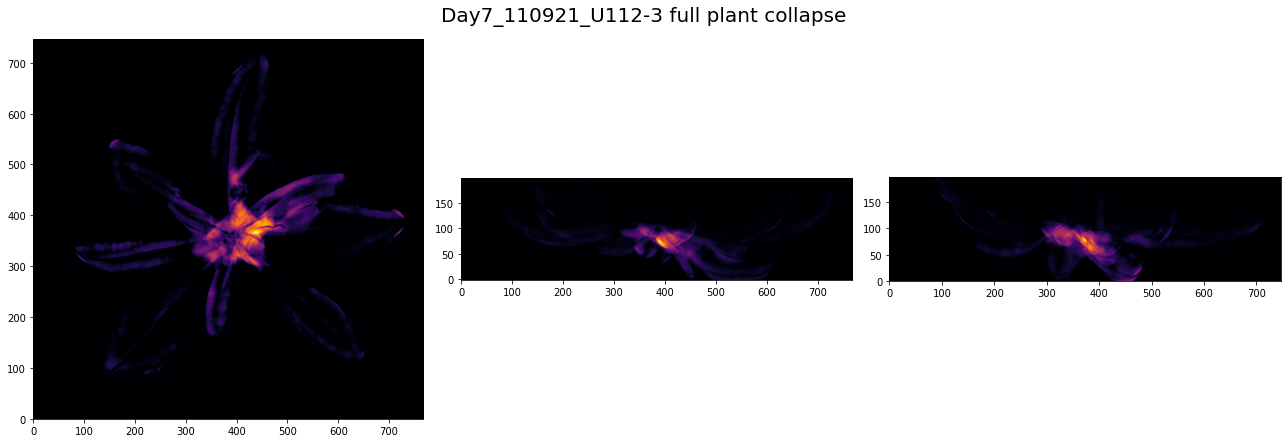

In [69]:
snaps = thales.collapse_dimensions(carab - bin_arab)
thales.plot_collapse_dimensions(snaps, bname, 'full plant')

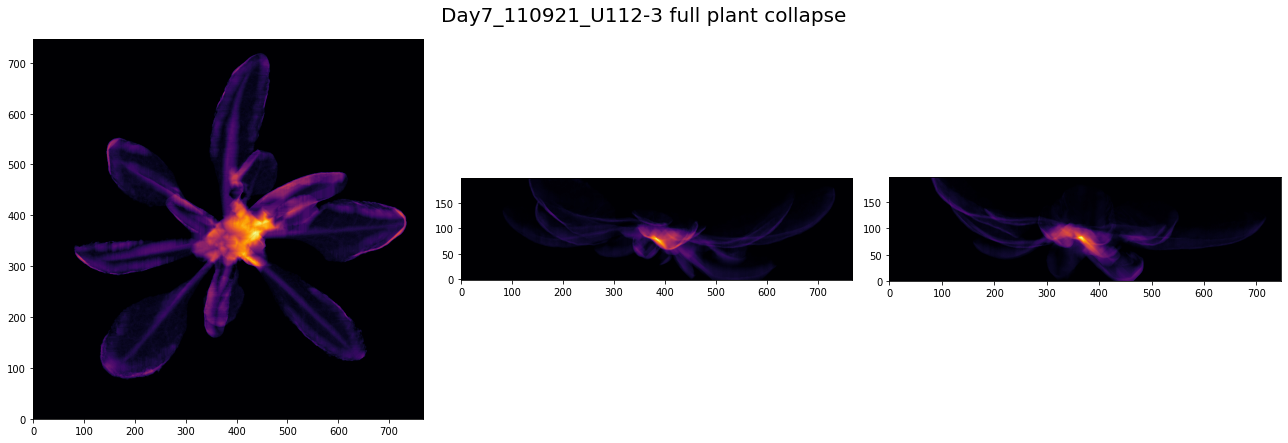

In [71]:
snaps = thales.collapse_dimensions(carab)
thales.plot_collapse_dimensions(snaps, bname, 'full plant')

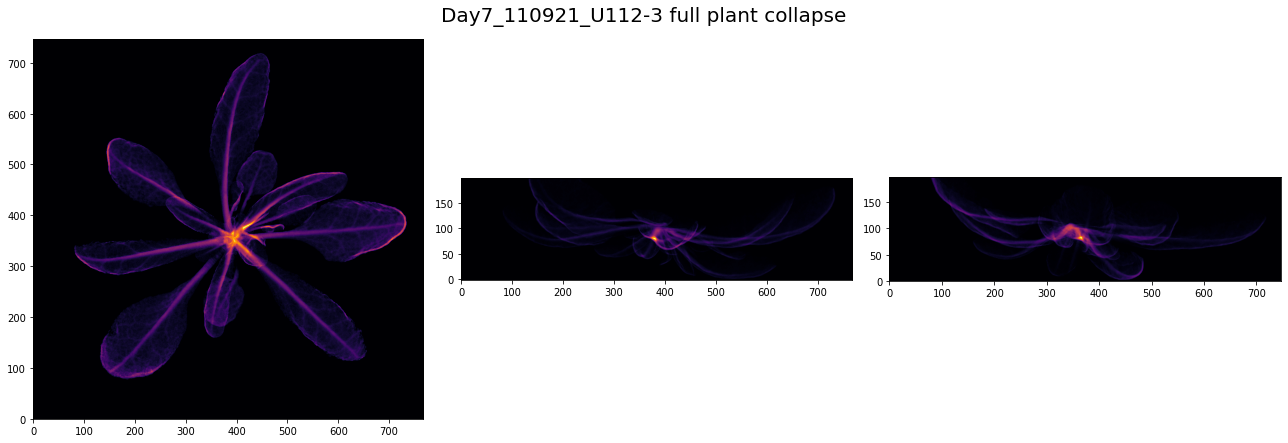

In [72]:
snaps = thales.collapse_dimensions(arab)
thales.plot_collapse_dimensions(snaps, bname, 'full plant')

In [70]:
print(np.sum(arab > 0))
print(np.sum(carab))
print(np.sum(bin_arab))

775871
1438643
775871


# Break up individual leaves (Work in progress)

- Current idea: Remove the rosette center, maybe that separates nicely the rest of leaves.

In [65]:
rosette_center = np.array(np.nonzero(snaps[0] == snaps[0].max())).squeeze()
#rosette_center = np.mean(coords, axis=0)
print(rosette_center)
print(plant.shape)

[421 619]
(305, 926, 816)


In [64]:
cil_dist = np.sqrt((coords[:,1] - rosette_center[0])**2 + (coords[:,2] - rosette_center[1])**2)
cil_dist

array([381.13098085, 381.1795663 , 381.23076866, ..., 881.12634702,
       881.99549264, 882.8649153 ])

In [41]:
cil_size = 50
out_cil = np.zeros(plant.shape, dtype=bool)
out_cil[tuple(coords[cil_dist > cil_size, :].T)] = True

in_cil = np.zeros(plant.shape, dtype=bool)
in_cil[tuple(coords[cil_dist <= cil_size, :].T)] = True

### I need to figure out how to get the rosette in the first place...

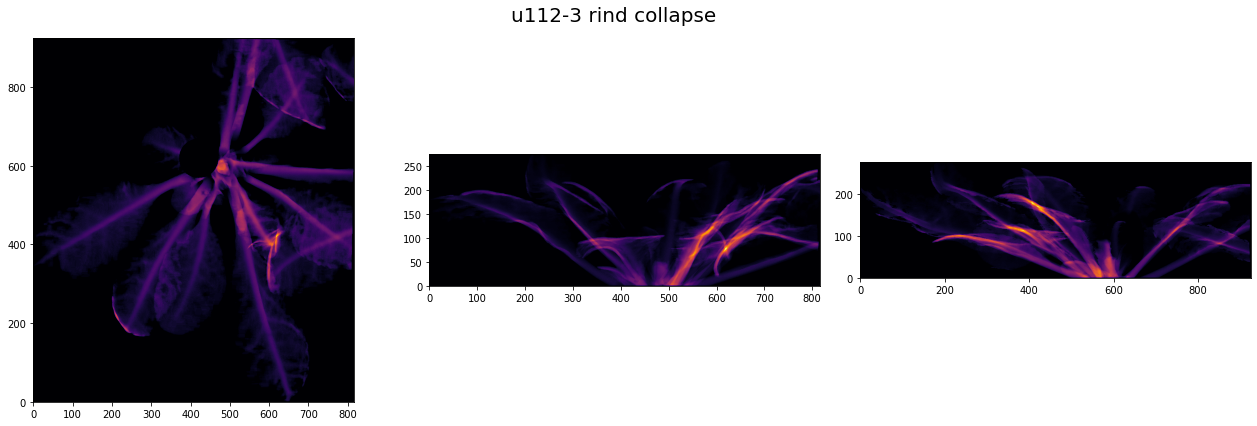

In [42]:
snaps = thales.collapse_dimensions(out_cil)
thales.plot_collapse_dimensions(snaps, bname, 'rind')

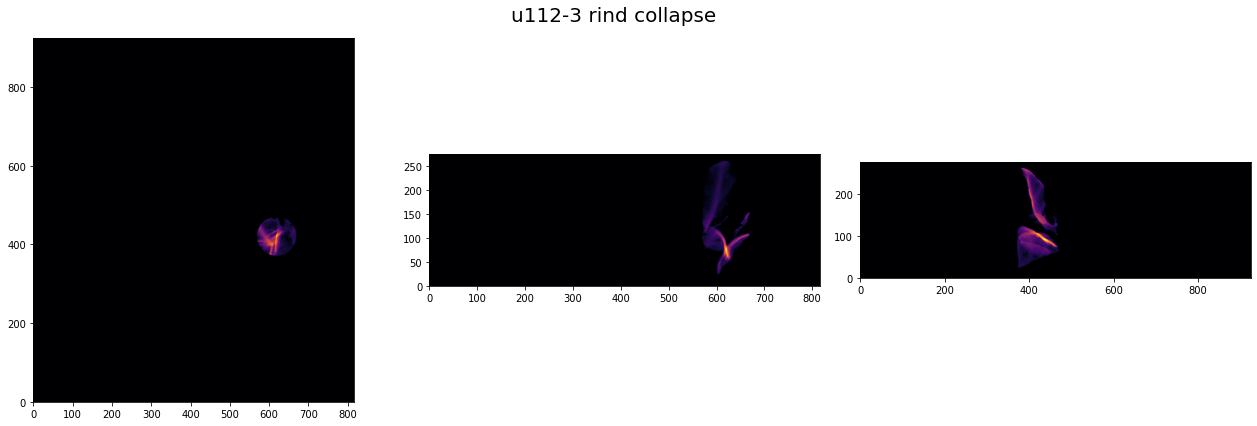

In [33]:
snaps = thales.collapse_dimensions(in_cil)
thales.plot_collapse_dimensions(snaps, bname, 'rind')

In [158]:
filename = dst + bname + '_pot{}_incylinder.csv'.format(pidx)
print(filename)
np.savetxt(filename, thales.tiff2coords(in_cil)+1, delimiter=',', fmt='%d')

../leaves/col-0/pot2/col-0_pot2_incylinder.csv


In [159]:
labels,num = ndimage.label(out_cil, structure=ndimage.generate_binary_structure(raw.ndim, 1))
regions = ndimage.find_objects(labels)
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

188 [184611 133627 121298  83466  75202  70643  58868  45918   3027     56
     40     25     23     22     21     18     17     16     15     15]


In [160]:
cutoff = 1e-2
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(raw.ndim, 2)
snaps = []

for j in range(len(regions)):
    i = argsort_hist[j]
    r = regions[i]
    if(hist[i]/sz_hist > cutoff):
        mask = labels[r]==i+1
        box = out_cil[r].copy()
        box[~mask] = 0
        box[box > 0] = 1
        #box = ndimage.grey_dilation(box, size=(3,7,7), mode='mirror')
        #box = ndimage.grey_dilation(box, size=(3,7,7), mode='mirror')
        
        leaf = plant[r]*box
        snap = thales.collapse_dimensions(leaf)
        snaps.append(snap[0])
        
        filename = dst + 'leaf_{:02d}.tif'.format(j)
        print(filename)
        tf.imwrite(filename, leaf, photometric='minisblack', compress=3)
        
print('Large components: ', len(snaps))

../leaves/col-0/pot2/leaf_00.tif
../leaves/col-0/pot2/leaf_01.tif
../leaves/col-0/pot2/leaf_02.tif
../leaves/col-0/pot2/leaf_03.tif
../leaves/col-0/pot2/leaf_04.tif
../leaves/col-0/pot2/leaf_05.tif
../leaves/col-0/pot2/leaf_06.tif
../leaves/col-0/pot2/leaf_07.tif
Large components:  8


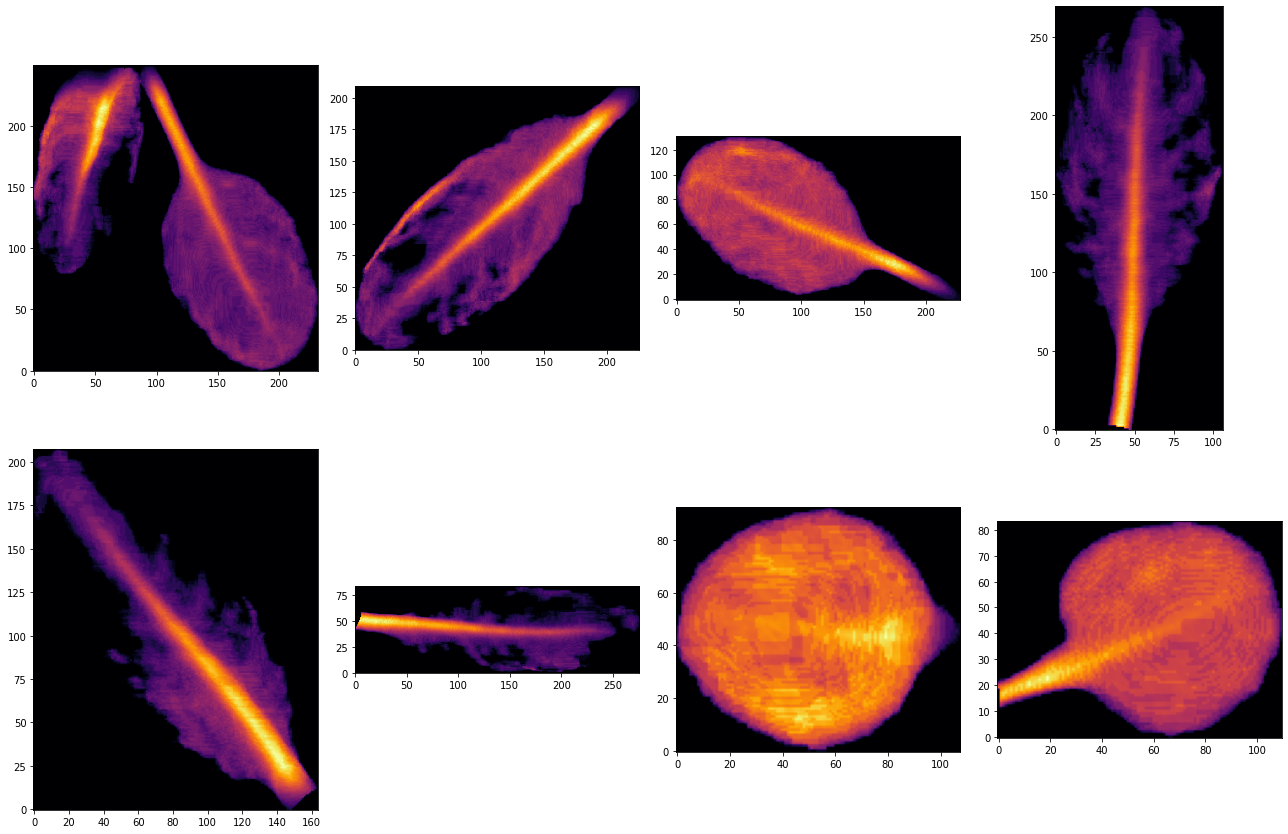

In [161]:
fig, ax = plt.subplots(2,4, figsize=(18,12))

idx = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].imshow(snaps[idx], cmap='inferno', origin='lower');
        idx += 1

fig.tight_layout()
#plt.savefig('separated_leaves_closeup_{}.jpg'.format(pidx), dpi=150, pil_kwargs={'optimize':True})

In [72]:
dtedt = ndimage.distance_transform_edt(leaf)#, metric='taxicab')
maxd = np.max(dtedt)
print(maxd)

36.0


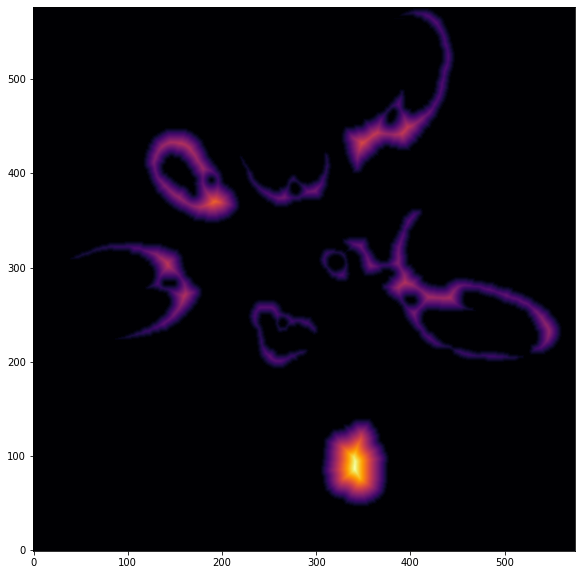

In [79]:
foo = leaf[ss].copy()
foo[foo > 0] = 1
bar = ndimage.distance_transform_edt(foo)
print(bar.max())

plt.figure(figsize=(10,10))
plt.imshow(bar, cmap='inferno', origin='lower');

In [98]:
coords = peak_local_max(bar, footprint=np.ones((3, 3)), labels=foo,
                        min_distance=50, threshold_rel=0.5)
mask = np.zeros(bar.shape, dtype=bool)
mask[tuple(coords.T)] = True
mask = ndimage.binary_dilation(mask, iterations=5)
markers, num = ndimage.label(mask)
print(num, 'components')

5 components


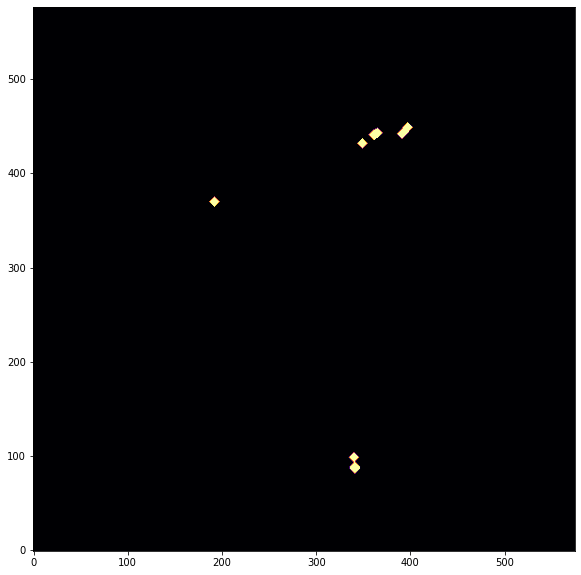

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(mask, cmap='inferno', origin='lower');

In [83]:
coords = peak_local_max(dtedt, min_distance=6,
                        threshold_abs=0.8*maxd, footprint=np.ones((3, 3, 3)), 
                        labels=box, exclude_border=False)
print(coords.shape)
print(coords)

(278, 3)
[[  1 112  86]
 [  1 116  84]
 [  3 117  81]
 [  6 119  73]
 [  6 119  74]
 [  6 120  72]
 [  6 120  73]
 [  6 121  72]
 [  6 122  71]
 [  3 122  75]
 [  3 122  74]
 [  3 121  77]
 [  3 121  76]
 [  3 120  78]
 [  3 120  77]
 [  3 119  78]
 [  3 118  79]
 [  5 120  75]
 [  3 117  80]
 [  3 116  81]
 [  7 118  72]
 [  4 119  77]
 [  4 120  76]
 [  4 121  74]
 [  5 120  74]
 [  5 120  73]
 [  5 119  76]
 [  5 121  74]
 [  5 121  75]
 [  5 122  72]
 [  5 122  73]
 [  5 123  71]
 [  5 123  72]
 [  7 120  71]
 [  4 123  73]
 [  4 123  72]
 [  4 122  75]
 [  4 122  74]
 [  4 122  73]
 [  4 121  76]
 [  4 121  75]
 [  3 112  83]
 [  3 111  84]
 [  5 121  73]
 [  3 110  85]
 [  2 110  87]
 [  2 110  86]
 [  3 110  86]
 [  1 119  81]
 [  1 119  80]
 [  1 118  82]
 [  1 118  81]
 [  1 117  82]
 [  1 114  86]
 [  1 114  85]
 [  1 111  88]
 [  0 119  82]
 [  0 119  81]
 [  0 118  83]
 [  0 118  82]
 [  0 114  86]
 [  0 112  88]
 [  2 112  84]
 [  2 113  84]
 [  1 120  79]
 [  2 119  79]
 

In [88]:
mask = np.zeros(dtedt.shape, dtype=bool)
mask[tuple(coords.T)] = True
#mask = ndimage.binary_dilation(mask, iterations=6)

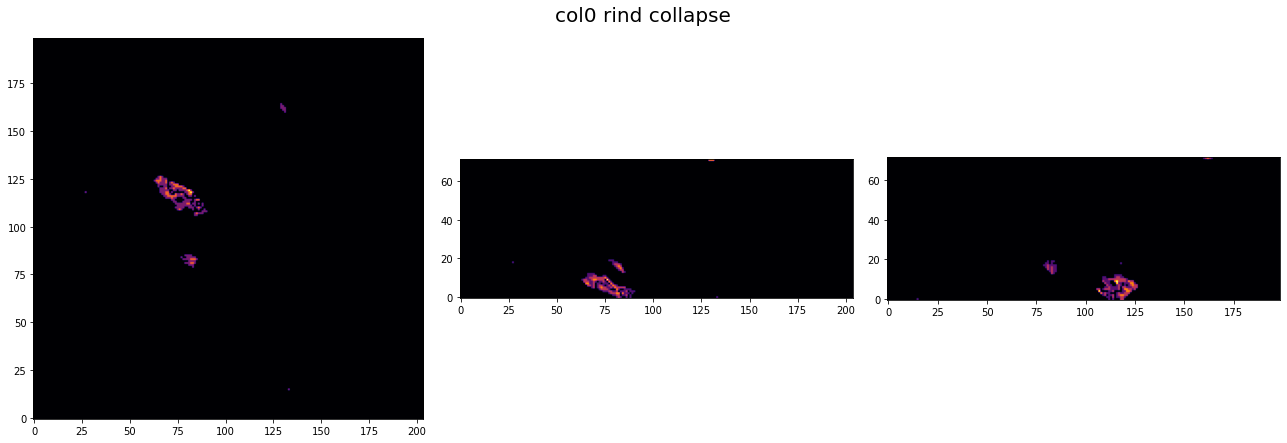

In [89]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(mask)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [ ]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(dtcdt > 8)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [ ]:
np.sum(dtcdt > 10 )

In [ ]:
size = (21,5,5)
prod = np.product(np.array(size))

bvg2 = ndimage.uniform_filter(bavg2, size=size, output = float)
bvg2 = (prod*bvg2).astype(np.uint)
print(prod)

In [ ]:
mimg = timg.copy()
mimg[avg < 15] = 0
mimg[bvg < 275] = 0
mimg[bvg2 < 400] = 0

In [ ]:



# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndimage.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, num = ndimage.label(mask)
print(num, 'labels')
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()

In [ ]:
tuple(coords.T)